# DROP ROBOT FROM MODELS

# Data Import

In [1]:
%%time

import os
import math
import datetime
import numpy as np
import pandas as pd
from copy import copy
from tqdm import tqdm

# Dictionaries
import json
from pprint import pprint

# Iterate in loops
import itertools
from itertools import zip_longest

# Simpsons integration
from numpy import trapz
from scipy.integrate import simps

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt

# To display df nicely in loops
from IPython.display import display 
# display(df1.head()) 
# display(df2.head())

# Display rows and columns Pandas
pd.options.display.max_columns = 100
pd.set_option('display.max_rows',100)

Wall time: 1.48 s


In [2]:
import os
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression

from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn import metrics
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_poisson_deviance
from sklearn.metrics import mean_gamma_deviance

In [3]:
# Prints the current working directory
os.getcwd()
# os.listdir()

'C:\\Users\\fahad\\MegaSync\\NMBU\\GitHub\\vPheno'

## Finding Username folder to make general path for multi PC use

In [4]:
username = str(os.getcwd()).split('\\')[2]
user_path = r'C:/Users/'+username+'/'
username, user_path

('fahad', 'C:/Users/fahad/')

## Importing Data

In [5]:
main_path = r'./Data/'
# path = r'./Data/3. merged data/'
path = r'./Data/3. merged data/'
export_path = './Data/4. results/'


# Create export_path folder if not exists already
os.makedirs(path, exist_ok=True)
os.makedirs(export_path, exist_ok=True)

os.listdir(path)

['Graminor_2019_Simps.csv',
 'Graminor_2019_Trapz.csv',
 'Graminor_2020_Simps.csv',
 'Graminor_2020_Trapz.csv',
 'Masbasis_2019_Simps.csv',
 'Masbasis_2019_Trapz.csv',
 'Masbasis_2020_Simps.csv',
 'Masbasis_2020_Trapz.csv',
 'Robot_2020_Simps.csv',
 'Robot_2020_Trapz.csv',
 'Staur_2019_Simps.csv',
 'Staur_2019_Trapz.csv',
 'Staur_2020_Simps.csv',
 'Staur_2020_Trapz.csv']

In [6]:
# Making dictionary of files in each folder, in case there are multiple types of data
dict_paths = {}
def explore(starting_path):
    for dirpath, dirnames, filenames in os.walk(starting_path):
        dict_paths[dirpath.split('/')[-2]] = filenames
#     pprint(dict_paths)
explore(path)

# Data Preparation
## Creating list of complete files

In [7]:
# Get the list of all files in directory tree at given path

files_with_address = []
files_list = []

for (dirpath, dirnames, filenames) in os.walk(path):
    files_with_address += [os.path.join(dirpath, file) for file in filenames]
    files_list.extend(filenames)
    
print(len(files_with_address), 'files found in the directory')
# files_with_address
files_list

14 files found in the directory


['Graminor_2019_Simps.csv',
 'Graminor_2019_Trapz.csv',
 'Graminor_2020_Simps.csv',
 'Graminor_2020_Trapz.csv',
 'Masbasis_2019_Simps.csv',
 'Masbasis_2019_Trapz.csv',
 'Masbasis_2020_Simps.csv',
 'Masbasis_2020_Trapz.csv',
 'Robot_2020_Simps.csv',
 'Robot_2020_Trapz.csv',
 'Staur_2019_Simps.csv',
 'Staur_2019_Trapz.csv',
 'Staur_2020_Simps.csv',
 'Staur_2020_Trapz.csv']

# Data Checking/control

## Check for duplicate filenames

In [8]:
print('Total number of files are :', len(files_list))

print('Number of unique file names are:', len(set(files_list)))

print('There is/are', len(files_list) - len(set(files_list)),'duplicate file name/names.')
if len(files_list) - len(set(files_list)) > 0:
    raise NameError

Total number of files are : 14
Number of unique file names are: 14
There is/are 0 duplicate file name/names.


# Importing data files to Pandas

In [9]:
   
%%time

all_df = []
for data in files_with_address:
    file_name = os.path.splitext(os.path.basename(data))[0]

    # Replce all invalid characters in the name
    file_name = file_name.replace(" ", "_")
    file_name = file_name.replace("-", "_")
    file_name = file_name.replace(")", "")
    file_name = file_name.replace("(", "")
    df_name = file_name.replace(".", "")
    # Test: Check if the same date is already present in the current dict key
    if df_name in all_df:
        print(f'A file with the same name {df_name} has already been imported. \n Please check if there is duplication of data.')
        raise NameError
    all_df.append(df_name)

    locals()[df_name] = pd.read_csv(data, index_col=False)
    print(df_name, '=====', locals()[df_name].shape)
# all_df

Graminor_2019_Simps ===== (600, 160)
Graminor_2019_Trapz ===== (600, 160)
Graminor_2020_Simps ===== (800, 160)
Graminor_2020_Trapz ===== (800, 160)
Masbasis_2019_Simps ===== (528, 162)
Masbasis_2019_Trapz ===== (528, 162)
Masbasis_2020_Simps ===== (659, 164)
Masbasis_2020_Trapz ===== (659, 164)
Robot_2020_Simps ===== (96, 164)
Robot_2020_Trapz ===== (96, 164)
Staur_2019_Simps ===== (1328, 163)
Staur_2019_Trapz ===== (1328, 163)
Staur_2020_Simps ===== (1504, 161)
Staur_2020_Trapz ===== (1504, 161)
Wall time: 424 ms


In [10]:
all_df_simps = [x for x in all_df if 'Simps' in x]
all_df_trapz = [x for x in all_df if 'Trapz' in x]
all_df_simps, all_df_trapz

(['Graminor_2019_Simps',
  'Graminor_2020_Simps',
  'Masbasis_2019_Simps',
  'Masbasis_2020_Simps',
  'Robot_2020_Simps',
  'Staur_2019_Simps',
  'Staur_2020_Simps'],
 ['Graminor_2019_Trapz',
  'Graminor_2020_Trapz',
  'Masbasis_2019_Trapz',
  'Masbasis_2020_Trapz',
  'Robot_2020_Trapz',
  'Staur_2019_Trapz',
  'Staur_2020_Trapz'])

Old  
Masbasis_2019 ===== (528, 160)  
Masbasis_2020 ===== (637, 162)  
Robot_2020 ===== (96, 162)  
Staur_2019 ===== (162, 160)  

In [11]:
print(f'Total imported {len(all_df)}')
all_df

Total imported 14


['Graminor_2019_Simps',
 'Graminor_2019_Trapz',
 'Graminor_2020_Simps',
 'Graminor_2020_Trapz',
 'Masbasis_2019_Simps',
 'Masbasis_2019_Trapz',
 'Masbasis_2020_Simps',
 'Masbasis_2020_Trapz',
 'Robot_2020_Simps',
 'Robot_2020_Trapz',
 'Staur_2019_Simps',
 'Staur_2019_Trapz',
 'Staur_2020_Simps',
 'Staur_2020_Trapz']

# Finding yield columns

## Importing Weather variables list

In [12]:
a_file = open(main_path+'weather_columns.json', "r")
output_str = a_file.read()
# The file is imported as string

# Converting it to dictionary
weather_features = json.loads(output_str)
a_file.close()

# pprint(weather_features)

## Defining vategories of features

In [13]:
# ToDo: Add check for duplicate columns in the df

general_col_names = ['Plot_ID', 'Blue', 'Green', 'Red', 'RedEdge', 'NIR']

base_indices = ['Blue', 'Green', 'Red', 'RedEdge', 'NIR']

spectral_indices = ['NDVI', 'MTCI', 'DVI', 'GDVI', 'MTCI_CI', 'EXG', 'EXGR', 'RDVI',
                    'TDVI', 'GNDVI', 'NDRE', 'SCCI', 'EVI', 'TVI', 'VARI', 'GARI',
                    'GCI', 'GLI', 'NLI', 'MNLI', 'SAVI', 'GSAVI', 'OSAVI', 'GOSAVI',
                    'MSAVI2', 'MSR', 'GRVI', 'WDRVI', 'SR']
environment_var = weather_features+['Staur_Env', 'Vollebekk_Env']

# list_agg_df
yield_cols = ['GrainYield', 'Name', 'CodeName', 'Pedigree', 'Line', 'Heading_Date',
              'Maturity_Date', 'Days2Heading', 'Days2Maturity', 'Lodging']

# Counter for location of column in columns list

# Dict for saving the name and location of the yield column/s
loc_yield_cols = {}
for df in all_df:
    loc = 0
    for cols in locals()[df].columns.tolist():
        for y_col in yield_cols:
            if not cols.find(y_col):
                loc_yield_cols[cols+'_'+df] = loc
                print(f'\"{cols}\" column in {df} is the yield column\n as it contains the text \"{y_col}\". It is located at location {loc}')
        loc += 1

    yield_cols_found = list(loc_yield_cols.keys())
    target_cols=yield_cols_found[0]
loc_yield_cols

"GrainYield" column in Graminor_2019_Simps is the yield column
 as it contains the text "GrainYield". It is located at location 1
"Name" column in Graminor_2019_Simps is the yield column
 as it contains the text "Name". It is located at location 2
"Pedigree" column in Graminor_2019_Simps is the yield column
 as it contains the text "Pedigree". It is located at location 37
"GrainYield" column in Graminor_2019_Trapz is the yield column
 as it contains the text "GrainYield". It is located at location 1
"Name" column in Graminor_2019_Trapz is the yield column
 as it contains the text "Name". It is located at location 2
"Pedigree" column in Graminor_2019_Trapz is the yield column
 as it contains the text "Pedigree". It is located at location 37
"GrainYield" column in Graminor_2020_Simps is the yield column
 as it contains the text "GrainYield". It is located at location 1
"Name" column in Graminor_2020_Simps is the yield column
 as it contains the text "Name". It is located at location 2
"P

{'GrainYield_Graminor_2019_Simps': 1,
 'Name_Graminor_2019_Simps': 2,
 'Pedigree_Graminor_2019_Simps': 37,
 'GrainYield_Graminor_2019_Trapz': 1,
 'Name_Graminor_2019_Trapz': 2,
 'Pedigree_Graminor_2019_Trapz': 37,
 'GrainYield_Graminor_2020_Simps': 1,
 'Name_Graminor_2020_Simps': 2,
 'Pedigree_Graminor_2020_Simps': 37,
 'GrainYield_Graminor_2020_Trapz': 1,
 'Name_Graminor_2020_Trapz': 2,
 'Pedigree_Graminor_2020_Trapz': 37,
 'GrainYield_Masbasis_2019_Simps': 1,
 'Name_Masbasis_2019_Simps': 2,
 'Line_Masbasis_2019_Simps': 3,
 'Days2Heading_Masbasis_2019_Simps': 4,
 'Days2Maturity_Masbasis_2019_Simps': 39,
 'GrainYield_Masbasis_2019_Trapz': 1,
 'Name_Masbasis_2019_Trapz': 2,
 'Line_Masbasis_2019_Trapz': 3,
 'Days2Heading_Masbasis_2019_Trapz': 4,
 'Days2Maturity_Masbasis_2019_Trapz': 39,
 'GrainYield_Masbasis_2020_Simps': 1,
 'Name_Masbasis_2020_Simps': 2,
 'Line_Masbasis_2020_Simps': 3,
 'Maturity_Date_Masbasis_2020_Simps': 4,
 'Days2Heading_Masbasis_2020_Simps': 5,
 'Days2Maturity_Masba

# Dropping unnecessary columns


In [14]:
# Dropping unnecessary columns

for df in all_df:
    print(df)
    temp_df = locals()[df].copy()
    locals()[df] = temp_df[base_indices+spectral_indices+environment_var+['Name','GrainYield']]

Graminor_2019_Simps
Graminor_2019_Trapz
Graminor_2020_Simps
Graminor_2020_Trapz
Masbasis_2019_Simps
Masbasis_2019_Trapz
Masbasis_2020_Simps
Masbasis_2020_Trapz
Robot_2020_Simps
Robot_2020_Trapz
Staur_2019_Simps
Staur_2019_Trapz
Staur_2020_Simps
Staur_2020_Trapz


# Dealing with Nan values

## Dropping Missing values

In [15]:
# Dropping rows with missing value in any column

for df in all_df:
    temp_df = locals()[df].copy()
    locals()[df] = temp_df.dropna(axis=0)
    print(temp_df.shape[0] - locals()[df].shape[0], ' rows dropped in ', df)
#     print(locals()[df].shape[0])

1  rows dropped in  Graminor_2019_Simps
1  rows dropped in  Graminor_2019_Trapz
1  rows dropped in  Graminor_2020_Simps
1  rows dropped in  Graminor_2020_Trapz
6  rows dropped in  Masbasis_2019_Simps
6  rows dropped in  Masbasis_2019_Trapz
116  rows dropped in  Masbasis_2020_Simps
116  rows dropped in  Masbasis_2020_Trapz
8  rows dropped in  Robot_2020_Simps
8  rows dropped in  Robot_2020_Trapz
0  rows dropped in  Staur_2019_Simps
0  rows dropped in  Staur_2019_Trapz
568  rows dropped in  Staur_2020_Simps
568  rows dropped in  Staur_2020_Trapz


Old  
6  rows dropped in  Masbasis_2019  
522  
94  rows dropped in  Masbasis_2020  
543  
0  rows dropped in  Robot_2020  
96  
0  rows dropped in  Staur_2019  
162  

# Preprocessing 

## Declaring functions

In [107]:
def training_gkf_std(model, X, y, gkf):
    current_model = make_pipeline(StandardScaler(), model)

    scores = cross_validate(current_model, X, y, cv=gkf,
                            scoring=('r2', 'neg_root_mean_squared_error'),
                            return_train_score=True)
    RMSE_test = "%0.2f (+/- %0.2f)" % (-1*scores['test_neg_root_mean_squared_error'].mean(), 
                                  -1*scores['test_neg_root_mean_squared_error'].std() * 2)
    RMSE_train = "%0.2f (+/- %0.2f)" % (-1*scores['train_neg_root_mean_squared_error'].mean(), 
                                  -1*scores['train_neg_root_mean_squared_error'].std() * 2)


    R2_test = "%0.2f (+/- %0.2f)" % (scores['test_r2'].mean(), 
                                  scores['test_r2'].std() * 2)
    R2_train = "%0.2f (+/- %0.2f)" % (scores['train_r2'].mean(), 
                                  scores['train_r2'].std() * 2)

    print(df,' : ', model)
    print(' RMSE Test:', RMSE_test, '       R2 Test:', R2_test)
    print('RMSE Train:', RMSE_train, '      R2 Train:', R2_train)
    
    current_model.fit(X, y)
    feat_import = np.array(current_model.steps[1][1].feature_importances_)
    
#     plot_feat_imp(X, y, current_model, training_features)
    
    return feat_import

In [108]:
def training_regr(model, X_train, y_train, X_test, y_test):
    current_model = make_pipeline(StandardScaler(), model)

    current_model.fit(X_train, y_train)
    y_pred_train = current_model.predict(X_train)
    y_pred = current_model.predict(X_test)
    
    scores = cross_validate(current_model, X, y, cv=gkf,
                            scoring=('r2', 'neg_root_mean_squared_error'),
                            return_train_score=True)
    RMSE_test = mean_squared_error(y_test, y_pred, squared=False)
    RMSE_train = mean_squared_error(y_train, y_pred_train, squared=False)


    R2_test = r2_score(y_test, y_pred)
    R2_train = r2_score(y_train, y_pred_train)
    
    print(' RMSE Test:', RMSE_test, '       R2 Test:', R2_test)
    print('RMSE Train:', RMSE_train, '      R2 Train:', R2_train)

    # Feature importance
    success = False
    while not success:
        try:
            feature_importance = current_model.steps[1][1].feature_importances_
            success = True
        except:
            feature_importance = None
            pass
    return feature_importance

In [166]:
# def plot_feat_imp(X_all = X, y_all = y, model_pipe = current_model, train_feat = training_features):
def plot_feat_imp(feature_importance, model, train_feat):
    # Plotting feature importance
    # Create arrays from feature importance and feature names

    feature_names = train_feat.copy()
    model_name =  str(model).split('(')[0]

#     # Create a DataFrame using a Dictionary
#     data={'feature_names':feature_names,'feature_importance':feature_importance}
#     feat_imp_df = pd.DataFrame(data)
    
    # Dropping features whose importance is zero
    importances, names = zip(*(
        (x, y) for x, y in zip(feature_importance, feature_names) if x >= 0.000005))
    print(type(names),names)
    print(type(importances), importances)
    # Sort the DataFrame in order decreasing feature importance
#     feat_imp_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(20,5))
    #Plot Searborn bar chart
    sns.barplot(y=importances, x=names, palette = 'winter'  )
    #Add chart labels
    plt.title(model_name + ' Feature Importance')
    plt.xticks(rotation=60)
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')
    # plt.savefig('Data/feature_importance_'+model_type+'.pdf',dpi=500, bbox_inches='tight')
    plt.show()

In [18]:
# from functions.plot_feature_importance import plot_feat_imp
# from functions.grid_search import grid
# from functions.test_data_regression import test_data_regression

## CPU Info

In [19]:
# Number of cores in the system being used
import multiprocessing
multiprocessing.cpu_count()

import psutil
psutil.cpu_count()

import cpuinfo
info = cpuinfo.get_cpu_info()
print('python_version:', info['python_version'])
print(info['arch'])
print(info['bits'])
print(info['count'])
print(info['arch_string_raw'])
print(info['vendor_id_raw'])
print(info['brand_raw'])
print(info['hz_advertised_friendly'])




python_version: 3.8.5.final.0 (64 bit)
X86_64
64
8
AMD64
GenuineIntel
Intel(R) Core(TM) i7-8565U CPU @ 1.80GHz
1.8000 GHz


# Correlation

In [20]:
# # Step 1 - Make a scatter plot with square markers, set column names as labels

# def heatmap(x, y, size):
#     fig_size=(15,10)

#     fig, ax = plt.subplots(figsize=fig_size)
    
#     # Mapping from column names to integer coordinates
#     x_labels = [v for v in x.unique()]
#     y_labels = [v for v in y.unique()]
#     x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
#     y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
    
#     size_scale = 50
#     ax.scatter(
#         x=x.map(x_to_num), # Use mapping for x
#         y=y.map(y_to_num), # Use mapping for y
#         s=size * size_scale, # Vector of square sizes, proportional to size parameter
#         marker='s' # Use square as scatterplot marker
#     )
    
#     # Show column labels on the axes
#     ax.set_xticks([x_to_num[v] for v in x_labels])
#     ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
#     ax.set_yticks([y_to_num[v] for v in y_labels])
#     ax.set_yticklabels(y_labels)
#     ax.grid(False, 'major')
#     ax.grid(True, 'minor')
#     ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
#     ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)
    


In [21]:
# for df in all_df:
#     print(df)
#     temp_df = locals()[df][base_indices+spectral_indices+['GrainYield']].copy()
#     data = temp_df

    
#     fig, ax = plt.subplots(figsize=(10, 8))
#     # mask
#     mask = np.triu(np.ones_like(data, dtype=np.bool))
#     # adjust mask and df
#     mask = mask[1:, :-1]
#     corr = data.iloc[1:,:-1].copy()
#     # plot heatmap
#     print('u1')

#     sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='Blues',
#                vmin=-1, vmax=1, cbar_kws={"shrink": .8})
#     # yticks
#     print('u2')
#     # plt.yticks(rotation=0)
#     print('u3')

#     plt.show()
#     print('u4')


In [22]:
# all_df

## Scatter Plot

In [23]:
# for df in all_df_simps:
#     print(df)
#     temp_df = locals()[df][base_indices+spectral_indices+['GrainYield']].copy()
#     data = temp_df
#     for col in base_indices:
#         print(df)
#         df_a = temp_df[col]
#         df_b = temp_df['GrainYield']


#         fig, ax = plt.subplots(1, figsize=(12,8))
#         sns.kdeplot(df_a, df_b, cmap='Blues',
#                    shade=True, shade_lowest=False, clip=(-1,300))
#         plt.scatter(df_a, df_b, color='orangered')
#         plt.show()

In [24]:
# for df in all_df_simps[0]:
#     print(df)
#     temp_df = locals()[df]['NDVI','GrainYield'].copy()
#     data = temp_df
#     for col in base_indices:
#         print(df)
#         df_a = temp_df[col]
#         df_b = temp_df['GrainYield']


#         fig, ax = plt.subplots(1, figsize=(12,8))
#         sns.kdeplot(df_a, df_b, cmap='Blues',
#                    shade=True, shade_lowest=False, clip=(-1,300))
#         plt.scatter(df_a, df_b, color='orangered')
#         plt.show()

## Heat Map

In [25]:
# for df in all_df_simps:
#     print(df)
#     temp_df = locals()[df][base_indices+spectral_indices+['GrainYield']].copy()
#     data = temp_df
#     columns = temp_df.columns
#     corr = data.corr()
#     fig_size=(15,10)

#     fig, ax = plt.subplots(figsize=fig_size)
#     ax = sns.heatmap(
#         corr, 
#         vmin=-1, vmax=1, center=0,
#         cmap=sns.diverging_palette(20, 220, n=200),
#         square=True
#     )
#     ax.set_xticklabels(
#         ax.get_xticklabels(),
#         rotation=45,
#         horizontalalignment='right'
#     );
#     plt.show()

# ML Models

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import PLSRegression

from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GroupKFold

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import time, datetime
from datetime import datetime as dt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
# import xgboost as xgb
from sklearn.linear_model import Lasso
# from catboost import CatBoostRegressor

import time, datetime
from datetime import datetime as dt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


## List of models

In [27]:
models = [
#          CatBoostRegressor(depth=8),
         RandomForestRegressor(random_state=1, n_jobs = -1)]
from sklearn.linear_model import LassoCV
# models = [Lasso()]

In [28]:
for model in models:
    print(str(model).split('(')[0])

RandomForestRegressor


### Deep Learning Model

## Variations of data processing

### With Simpsons Integration

### Trapeziodal Integration

### Without any integration

### Without weather data

## Variations in Datasets

In [52]:
# training_features = base_indices+spectral_indices+environment_var
training_features = base_indices+spectral_indices
target_features = ['GrainYield']
group_feature = ['Name']

### Within same datasets:

Graminor_2019_Trapz  :  RandomForestRegressor(n_jobs=-1, random_state=1)
 RMSE Test: 44.08 (+/- -2.85)        R2 Test: 0.23 (+/- 0.05)
RMSE Train: 16.11 (+/- -0.33)       R2 Train: 0.90 (+/- 0.00)


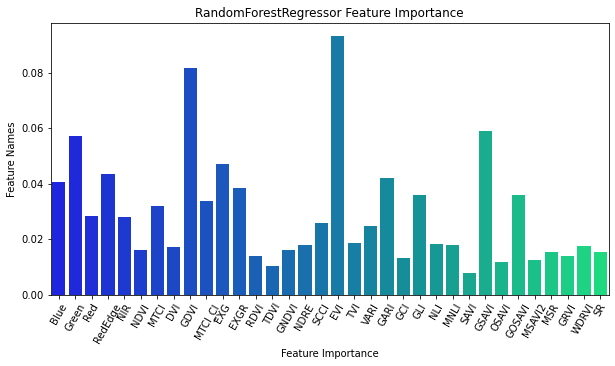

Graminor_2020_Trapz  :  RandomForestRegressor(n_jobs=-1, random_state=1)
 RMSE Test: 47.74 (+/- -3.25)        R2 Test: 0.77 (+/- 0.05)
RMSE Train: 17.66 (+/- -0.71)       R2 Train: 0.97 (+/- 0.00)


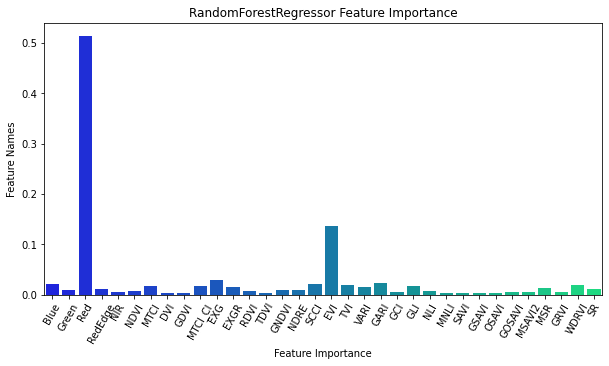

Masbasis_2019_Trapz  :  RandomForestRegressor(n_jobs=-1, random_state=1)
 RMSE Test: 70.83 (+/- -7.92)        R2 Test: 0.28 (+/- 0.28)
RMSE Train: 31.70 (+/- -4.71)       R2 Train: 0.86 (+/- 0.06)


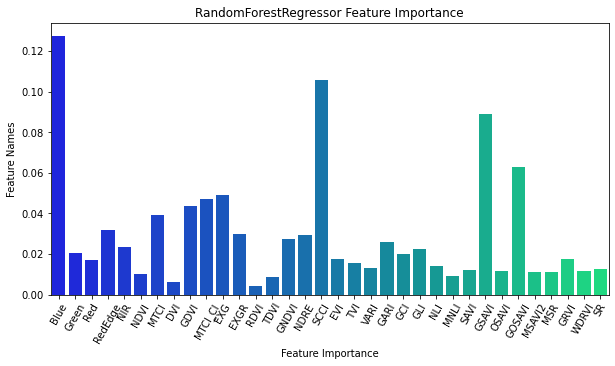

Masbasis_2020_Trapz  :  RandomForestRegressor(n_jobs=-1, random_state=1)
 RMSE Test: 82.43 (+/- -6.17)        R2 Test: 0.25 (+/- 0.05)
RMSE Train: 30.80 (+/- -2.06)       R2 Train: 0.90 (+/- 0.01)


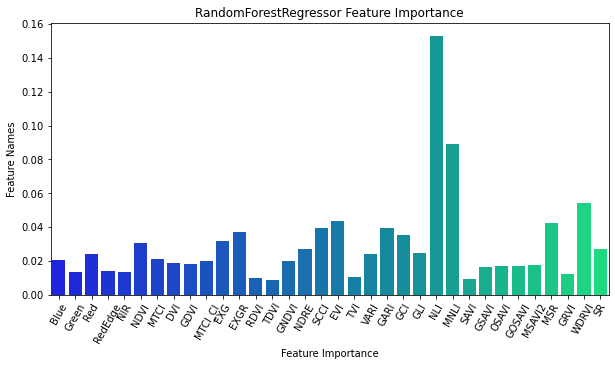

Robot_2020_Trapz  :  RandomForestRegressor(n_jobs=-1, random_state=1)
 RMSE Test: 53.55 (+/- -5.07)        R2 Test: 0.71 (+/- 0.06)
RMSE Train: 18.93 (+/- -1.97)       R2 Train: 0.96 (+/- 0.01)


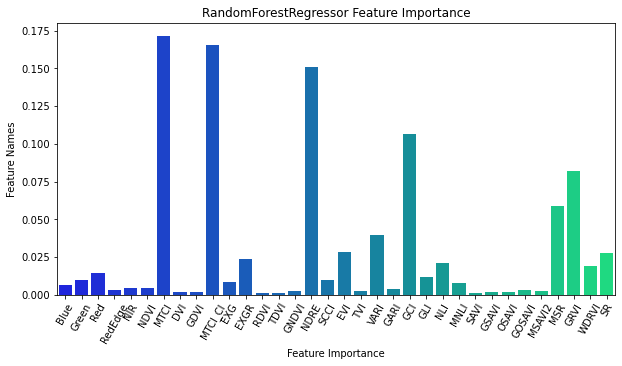

Staur_2019_Trapz  :  RandomForestRegressor(n_jobs=-1, random_state=1)
 RMSE Test: 71.35 (+/- -6.13)        R2 Test: 0.43 (+/- 0.05)
RMSE Train: 26.81 (+/- -1.19)       R2 Train: 0.92 (+/- 0.00)


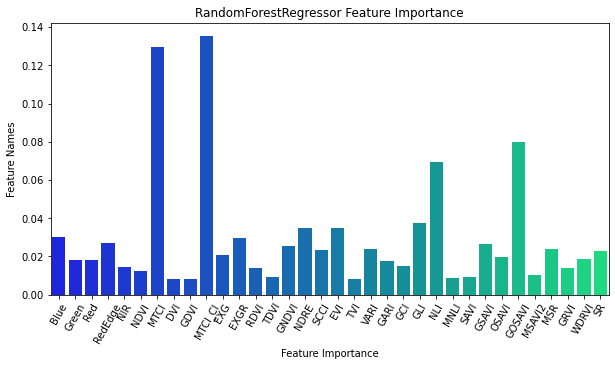

Staur_2020_Trapz  :  RandomForestRegressor(n_jobs=-1, random_state=1)
 RMSE Test: 51.79 (+/- -7.28)        R2 Test: 0.65 (+/- 0.10)
RMSE Train: 19.18 (+/- -1.32)       R2 Train: 0.95 (+/- 0.01)


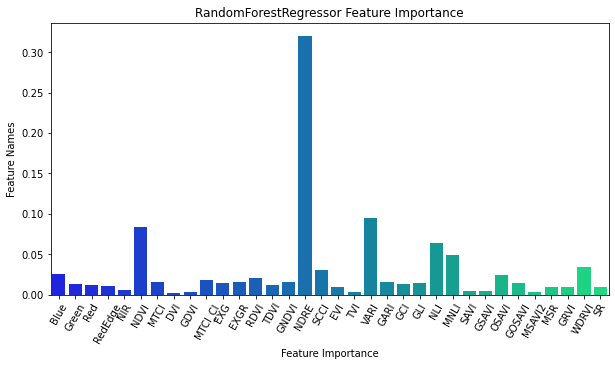

In [53]:
# Iterating through all possible permutations of the fields dataset
for df in all_df_trapz:
    df_ = locals()[df].copy()

    X = df_[training_features]
    y = df_[target_features].values.ravel()
    groups = df_[group_feature].values.ravel()

    gkf = list(GroupKFold(n_splits=3).split(X, y, groups))

    # Getting scores using cross_val_score
    for model in models:
        importances = training_gkf_std(model, X, y, gkf)
        plot_feat_imp(importances, model, training_features)

### One against all - one2one

In [34]:
training_features = base_indices+spectral_indices+environment_var
# training_features = base_indices+spectral_indices
target_features = ['GrainYield']
group_feature = ['Name']

Training:  Graminor_2019_Simps Test:  Graminor_2020_Simps  :  RandomForestRegressor(n_jobs=-1, random_state=1)
 RMSE Test: 136.18743834013722        R2 Test: -0.8646786364715182
RMSE Train: 16.25559580697873       R2 Train: 0.8956659805877796


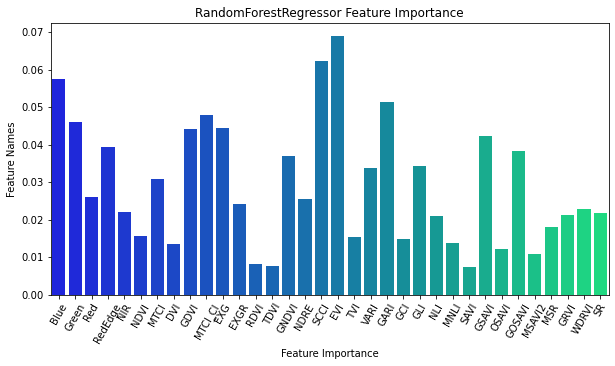

Training:  Graminor_2019_Simps Test:  Masbasis_2019_Simps  :  RandomForestRegressor(n_jobs=-1, random_state=1)
 RMSE Test: 85.5425638471397        R2 Test: -0.02919427293140875
RMSE Train: 16.25559580697873       R2 Train: 0.8956659805877796


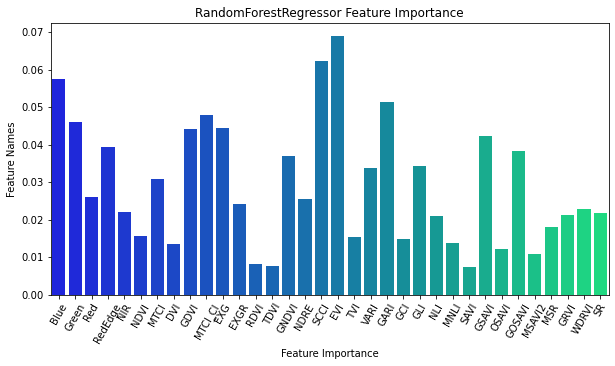

Training:  Graminor_2019_Simps Test:  Masbasis_2020_Simps  :  RandomForestRegressor(n_jobs=-1, random_state=1)
 RMSE Test: 131.1154449879814        R2 Test: -0.8816094356182336
RMSE Train: 16.25559580697873       R2 Train: 0.8956659805877796


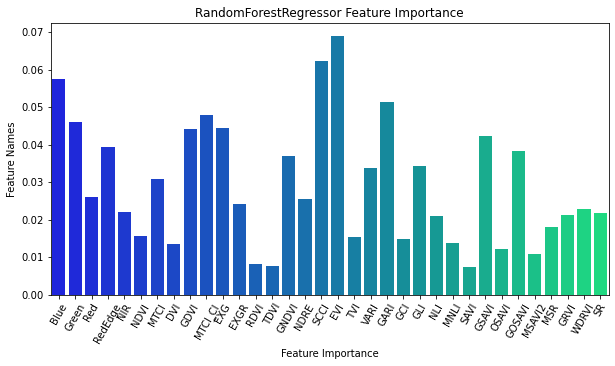

Training:  Graminor_2019_Simps Test:  Robot_2020_Simps  :  RandomForestRegressor(n_jobs=-1, random_state=1)
 RMSE Test: 104.12706039434815        R2 Test: -0.09498283573583244
RMSE Train: 16.25559580697873       R2 Train: 0.8956659805877796


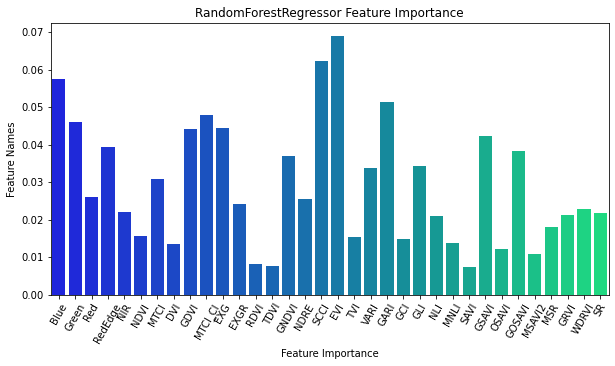

Training:  Graminor_2019_Simps Test:  Staur_2019_Simps  :  RandomForestRegressor(n_jobs=-1, random_state=1)
 RMSE Test: 118.81974608982652        R2 Test: -0.5651694742352229
RMSE Train: 16.255595806978725       R2 Train: 0.8956659805877797


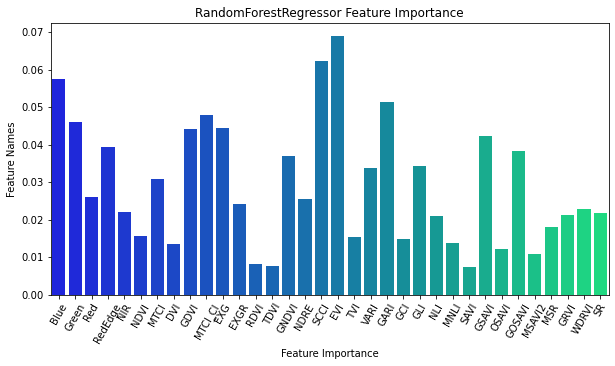

Training:  Graminor_2019_Simps Test:  Staur_2020_Simps  :  RandomForestRegressor(n_jobs=-1, random_state=1)
 RMSE Test: 90.52020317941428        R2 Test: -0.054666163461540185
RMSE Train: 16.25559580697873       R2 Train: 0.8956659805877796


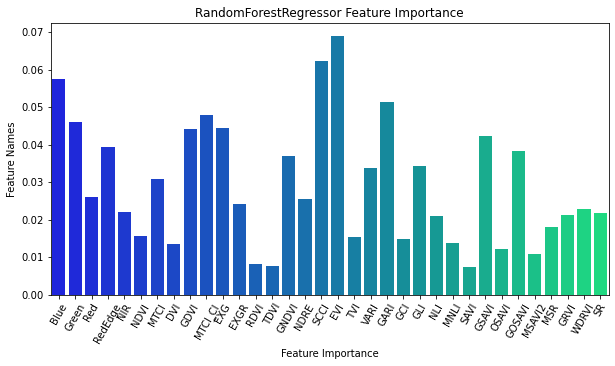

Training:  Graminor_2020_Simps Test:  Graminor_2019_Simps  :  RandomForestRegressor(n_jobs=-1, random_state=1)
 RMSE Test: 82.50559455835105        R2 Test: -1.6877381211365834
RMSE Train: 18.79138363092169       R2 Train: 0.9644984421365642


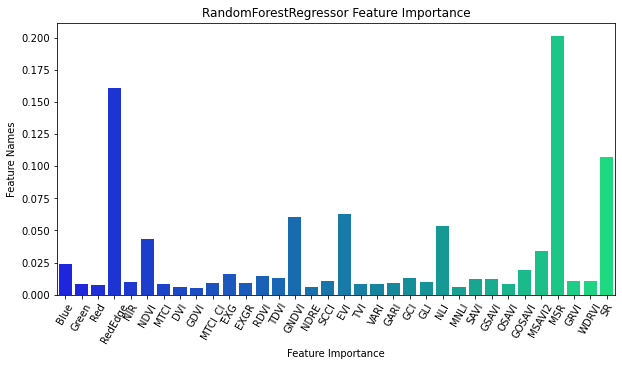

KeyboardInterrupt: 

In [88]:
# Iterating through all possible permutations of the fields dataset

for i in itertools.permutations(all_df_simps, 2):
    train_df = locals()[i[0]].copy()
    test_df = locals()[i[1]].copy()
    
    
    X_train = train_df[training_features]
    y_train = train_df[target_features].values.ravel()
    X_test = test_df[training_features]
    y_test = test_df[target_features].values.ravel()
    

    # Getting scores using cross_val_score
    for model in models:
        print('Training: ', i[0],'Test: ', i[1], ' : ', model)
        importances = training_regr(model, X_train, y_train, X_test, y_test)
        if importances is not None:
            plot_feat_imp(importances[:len(base_indices+spectral_indices)], model, base_indices+spectral_indices)

### One aganist all together

In [111]:
training_features = base_indices+spectral_indices+environment_var
# training_features = base_indices+spectral_indices
target_features = ['GrainYield']
group_feature = ['Name']

Training: All   Test:  Graminor_2019_Simps  :  RandomForestRegressor(n_jobs=-1, random_state=1)
 RMSE Test: 130.7540240885789        R2 Test: -5.750412025805035
RMSE Train: 24.86014387911824       R2 Train: 0.9546596330638297


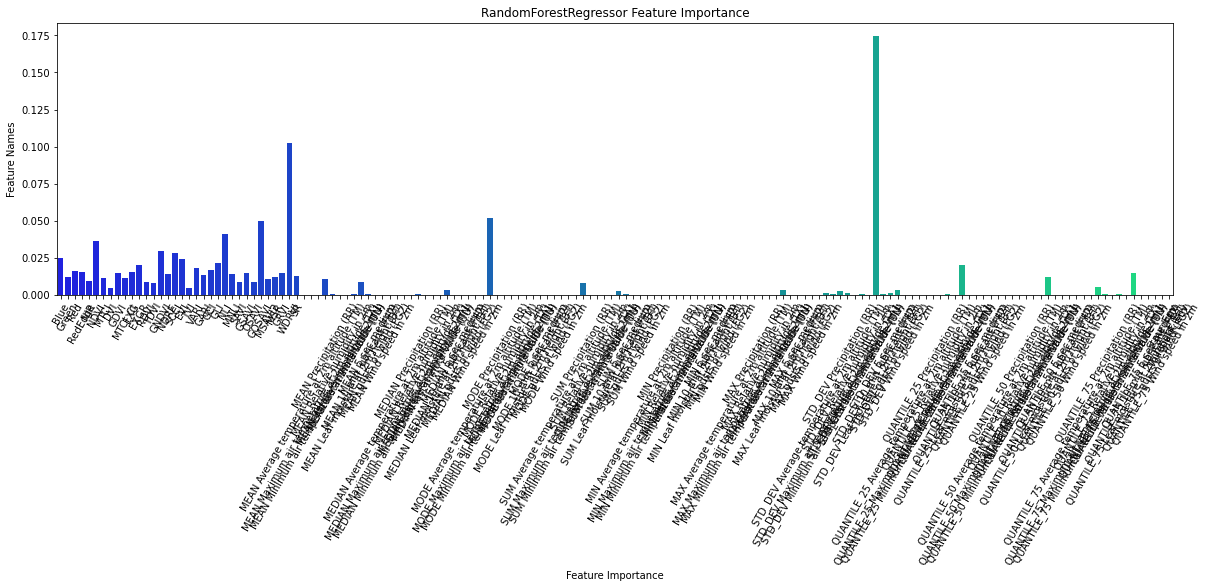

Training: All   Test:  Graminor_2020_Simps  :  RandomForestRegressor(n_jobs=-1, random_state=1)
 RMSE Test: 143.00649362075114        R2 Test: -1.0560866338619586
RMSE Train: 24.795068133313563       R2 Train: 0.9436780524041805


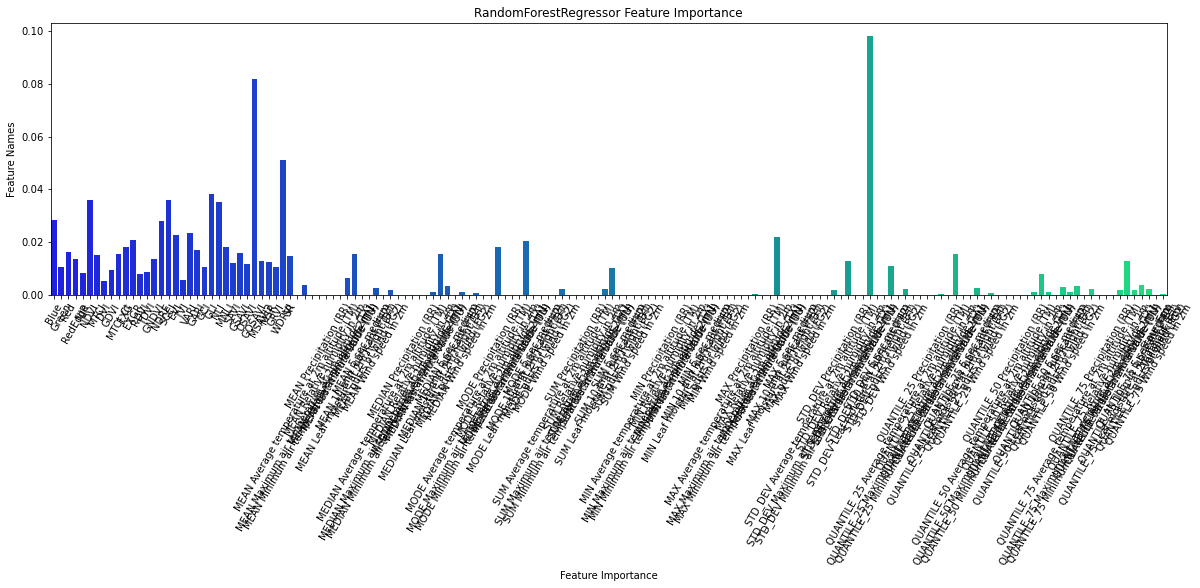

Training: All   Test:  Masbasis_2019_Simps  :  RandomForestRegressor(n_jobs=-1, random_state=1)
 RMSE Test: 160.1408463446771        R2 Test: -2.6069246885712642
RMSE Train: 22.822410710016598       R2 Train: 0.9595268491571672


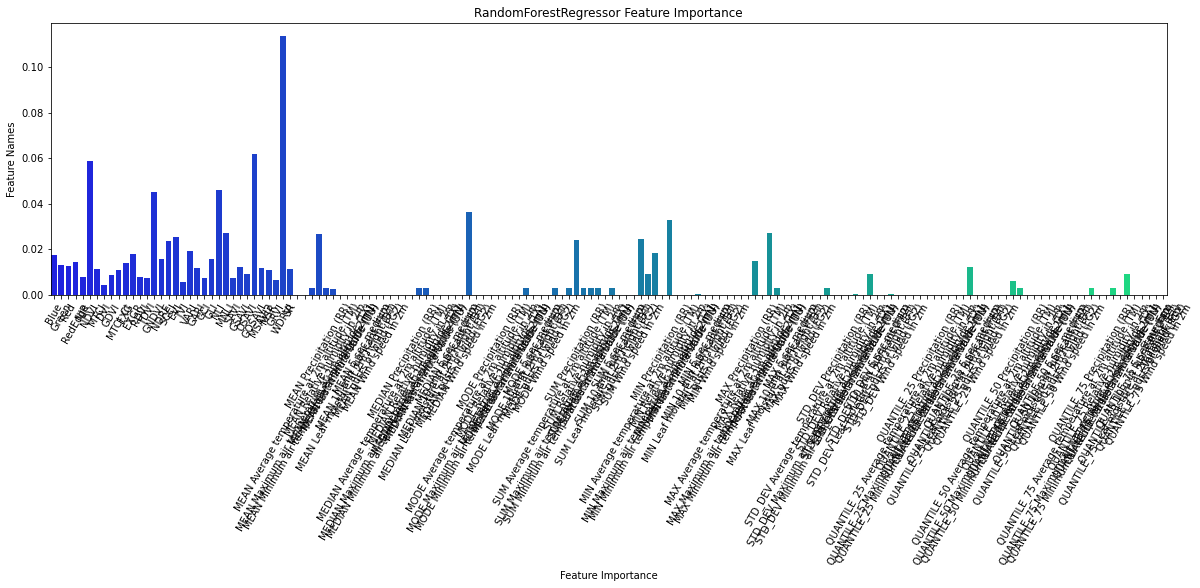

Training: All   Test:  Masbasis_2020_Simps  :  RandomForestRegressor(n_jobs=-1, random_state=1)
 RMSE Test: 203.41754568258222        R2 Test: -3.528961156656699
RMSE Train: 23.00964365338298       R2 Train: 0.955773992935115


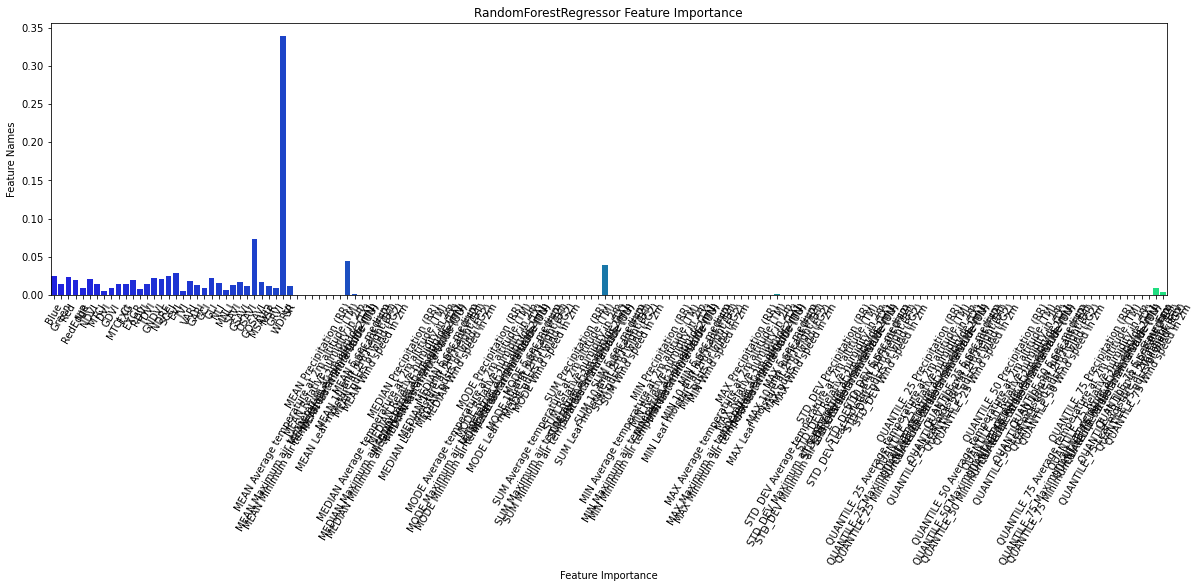

Training: All   Test:  Robot_2020_Simps  :  RandomForestRegressor(n_jobs=-1, random_state=1)


KeyboardInterrupt: 

In [114]:
# Iterating through all possible permutations of the fields dataset
for df in all_df_simps:
    
    temp_list = all_df_simps.copy()
    temp_list.remove(df)
    
    # Making list of df for conct before training
    temp_df_list = []
    for x in temp_list:
        temp_df_list.append(locals()[x])
    
    train_df = pd.concat(temp_df_list)
    test_df = locals()[df].copy()

    X_train = train_df[training_features]
    y_train = train_df[target_features].values.ravel()
    X_test = test_df[training_features]
    y_test = test_df[target_features].values.ravel()
    

    # Getting scores using cross_val_score
    for model in models:
        print('Training: All  ','Test: ', df, ' : ', model)
        importances = training_regr(model, X_train, y_train, X_test, y_test)
        if importances is not None:
#             plot_feat_imp(importances[:len(base_indices+spectral_indices)], model, base_indices+spectral_indices)
            plot_feat_imp(importances, model, training_features)

In [165]:
# Create a DataFrame using a Dictionary
data={'feature_names':importances,'feature_importance':training_features}
feat_imp_df = pd.DataFrame(data)

# Dropping features whose importance is zero
importances_x, names_x = zip(*(
    (x, y) for x, y in zip(importances, training_features) if x >= 0.000005))
print(type(names_x),names_x)
print(type(importances_x), importances_x)

<class 'tuple'> ('Blue', 'Green', 'Red', 'RedEdge', 'NIR', 'NDVI', 'MTCI', 'DVI', 'GDVI', 'MTCI_CI', 'EXG', 'EXGR', 'RDVI', 'TDVI', 'GNDVI', 'NDRE', 'SCCI', 'EVI', 'TVI', 'VARI', 'GARI', 'GCI', 'GLI', 'NLI', 'MNLI', 'SAVI', 'GSAVI', 'OSAVI', 'GOSAVI', 'MSAVI2', 'MSR', 'GRVI', 'WDRVI', 'SR', 'MEAN Average temperature at 2m altitude (TM)', 'MEAN Maximum air temperature at 2m altitude (TX)', 'MEAN Minimum air temperature at 2m altitude (TN)', 'MEAN Precipitation (RR)', 'MEAN Relative humidity in 2m', 'MEAN Relative humidity in 2m.1', 'MEAN last minute value (UU)', 'MEAN 10 min lubricant (FF2)', 'MEAN 5 sec medium', 'MEDIAN Average temperature at 2m altitude (TM)', 'MEDIAN Relative humidity in 2m', 'MEDIAN Relative humidity in 2m.1', 'MEDIAN last minute value (UU)', 'MEDIAN 10 min lubricant (FF2)', 'MEDIAN gusts of wind (FG2)', 'MEDIAN Wind speed in 2m', 'MODE Average temperature at 2m altitude (TM)', 'MODE Maximum air temperature at 2m altitude (TX)', 'MODE Minimum air temperature at 2m a

In [163]:
importances_x

NameError: name 'importances_x' is not defined

In [128]:
len(importances)
training_features

156

In [169]:
sns.barplot(y=importances_x, x=names_x, palette = 'winter'  )

AttributeError: 'bool' object has no attribute 'all'

In [172]:
for x in importances_x:
    print(type(x))

<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.fl

### 2019 Vollebekk vs 2019 Staur

In [ ]:
training_features = base_indices+spectral_indices+environment_var
# training_features = base_indices+spectral_indices
target_features = ['GrainYield']
group_feature = ['Name']

#### Training Staur, Test Vollebekk

In [167]:
# Iterating through all possible permutations of the fields dataset
    
temp_list = all_df_simps.copy()
temp_list.remove(df)

# Making list of training dfs for conct before training
train_df_list = []
for x in all_df_simps:
    if 'Staur' in x:
        print('Training:', x)
        train_df_list.append(locals()[x])

# Making list of test dfs for conct before training
test_df_list = []
for x in all_df_simps:
    if not 'Staur' in x and not 'Robot' in x:
        print('Test:', x)
        test_df_list.append(locals()[x])


train_df = pd.concat(temp_df_list)
test_df = pd.concat(test_df_list)

X_train = train_df[training_features]
y_train = train_df[target_features].values.ravel()
X_test = test_df[training_features]
y_test = test_df[target_features].values.ravel()


# Getting scores using cross_val_score
for model in models:
    print('Training: All  ','Test: ', df, ' : ', model)
    importances = training_regr(model, X_train, y_train, X_test, y_test)
    if importances is not None:
#             plot_feat_imp(importances[:len(base_indices+spectral_indices)], model, base_indices+spectral_indices)
        plot_feat_imp(importances, model, training_features)

Training: Staur_2019_Simps
Training: Staur_2020_Simps
Test: Graminor_2019_Simps
Test: Graminor_2020_Simps
Test: Masbasis_2019_Simps
Test: Masbasis_2020_Simps
Training: All   Test:  Staur_2020_Simps  :  RandomForestRegressor(n_jobs=-1, random_state=1)
 RMSE Test: 24.446623872952816        R2 Test: 0.9341263140516844
RMSE Train: 23.910550388026685       R2 Train: 0.9532865883762802
<class 'tuple'> ('Blue', 'Green', 'Red', 'RedEdge', 'NIR', 'NDVI', 'MTCI', 'DVI', 'GDVI', 'MTCI_CI', 'EXG', 'EXGR', 'RDVI', 'TDVI', 'GNDVI', 'NDRE', 'SCCI', 'EVI', 'TVI', 'VARI', 'GARI', 'GCI', 'GLI', 'NLI', 'MNLI', 'SAVI', 'GSAVI', 'OSAVI', 'GOSAVI', 'MSAVI2', 'MSR', 'GRVI', 'WDRVI', 'SR', 'MEAN Average temperature at 2m altitude (TM)', 'MEAN Maximum air temperature at 2m altitude (TX)', 'MEAN Minimum air temperature at 2m altitude (TN)', 'MEAN Precipitation (RR)', 'MEAN Relative humidity in 2m', 'MEAN Relative humidity in 2m.1', 'MEAN last minute value (UU)', 'MEAN 10 min lubricant (FF2)', 'MEAN 5 sec medium

AttributeError: 'bool' object has no attribute 'all'

<Figure size 1440x360 with 0 Axes>

#### Training Vollebekk, Test Staur

Test: Graminor_2019_Simps
Test: Graminor_2020_Simps
Test: Masbasis_2019_Simps
Test: Masbasis_2020_Simps
Training: Staur_2019_Simps
Training: Staur_2020_Simps
Training: All   Test:  Staur_2020_Simps  :  RandomForestRegressor(n_jobs=-1, random_state=1)
 RMSE Test: 23.313362122308423        R2 Test: 0.954071915050446
RMSE Train: 23.910550388026685       R2 Train: 0.9532865883762802


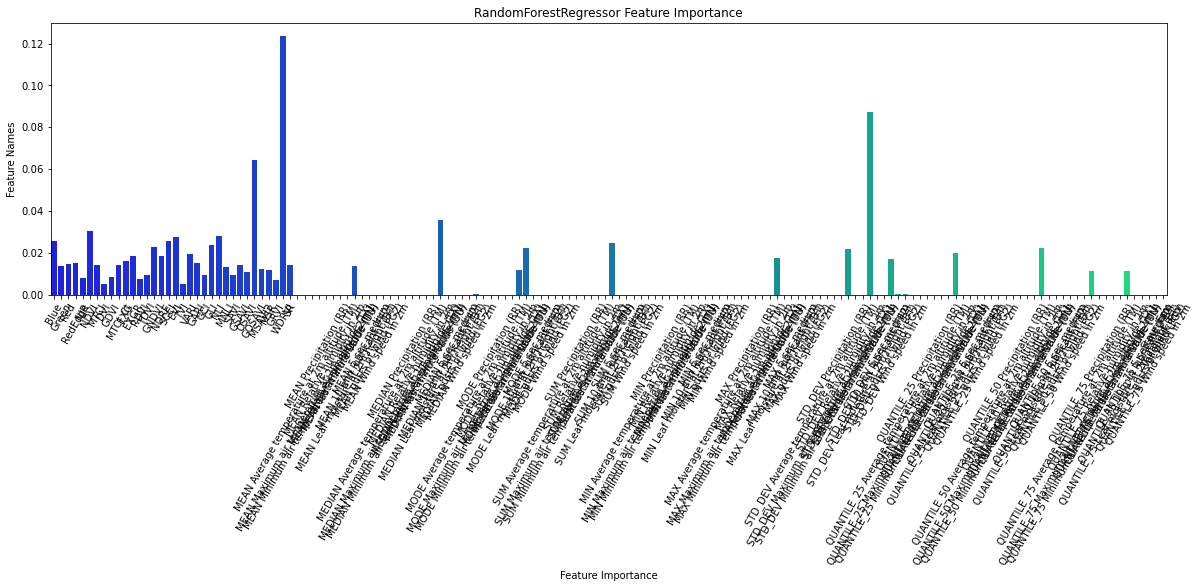

In [122]:
# Iterating through all possible permutations of the fields dataset
    
temp_list = all_df_simps.copy()
temp_list.remove(df)

# Making list of training dfs for conct before training
train_df_list = []
for x in all_df_simps:
    if not 'Staur' in x and not 'Robot' in x:
        print('Test:', x)
        train_df_list.append(locals()[x])

# Making list of test dfs for conct before training
test_df_list = []
for x in all_df_simps:
    if 'Staur' in x:
        print('Training:', x)
        test_df_list.append(locals()[x])



train_df = pd.concat(temp_df_list)
test_df = pd.concat(test_df_list)

X_train = train_df[training_features]
y_train = train_df[target_features].values.ravel()
X_test = test_df[training_features]
y_test = test_df[target_features].values.ravel()


# Getting scores using cross_val_score
for model in models:
    print('Training: All  ','Test: ', df, ' : ', model)
    importances = training_regr(model, X_train, y_train, X_test, y_test)
    if importances is not None:
#             plot_feat_imp(importances[:len(base_indices+spectral_indices)], model, base_indices+spectral_indices)
        plot_feat_imp(importances, model, training_features)

### 2020 Vollebekk vs 2020 Staur

###

###

### GroupKFold

In [71]:
gkf = list(GroupKFold(n_splits=3).split(X, y, group))

NameError: name 'X' is not defined

###

In [72]:
# Iterating through all possible permutations of the fields dataset
results = []
for df in all_df_simps:
    print(df)
    df_ = locals()[df]

    train_size = int(0.7*df_.shape[0])
    test_size = df_.shape[0] - train_size

    train_df = df_.iloc[:train_size, :].copy()
    test_df = df_.iloc[:test_size, :].copy()

    print(f"Train dataset: {df} {train_df['GrainYield'].isna().sum()}\
    \n Test dataset: {df} {test_df['GrainYield'].isna().sum()}")
    print('=>')


    # Dropping entries with grainyield missing
    train_df.dropna(subset=['GrainYield'], inplace=True)
    test_df.dropna(subset=['GrainYield'], inplace=True)

    #==============================================================================
    # Create separate train/test splits from Main data
    #==============================================================================
    X_train, y_train, = train_df[[x for x in train_df.columns if x not in yield_cols+id_cols_new]], train_df['GrainYield']
    X_test, y_test = test_df[[x for x in test_df.columns if x not in yield_cols+id_cols_new]], test_df['GrainYield']
    features = X_train.columns

    #==============================================================================
    # Scale features using StandardScaler class in scikit-learn 
    #==============================================================================

    # Initialise standard scaler and compute mean and STD from training data
    sc = StandardScaler()
    sc.fit(X_train)

    # Transform (standardise) both X_train and X_test with mean and STD from
    # training data
    X_train_std = sc.transform(X_train)
    X_test_std = sc.transform(X_test)
    print('RUNNING TRAINING')

    for model in models:
        print(model)
        acc, acc_train, imp = test_data_regression(model, features, X_train, X_train_std, y_train, X_test, X_test_std, y_test)
#         plot_feature_importance(imp,features,model)
    #         results.append([i[0], i[1], model, acc, acc_std, imp, imp_std])
        print('=============================================')


Graminor_2019_Simps
Train dataset: Graminor_2019_Simps 0    
 Test dataset: Graminor_2019_Simps 0
=>
RUNNING TRAINING
RandomForestRegressor(n_jobs=-1, random_state=1)


NameError: name 'test_data_regression' is not defined

In [ ]:
# Iterating through all possible permutations of the fields dataset
results = []
for df in all_df_trapz:
    print(df)
    df_ = locals()[df]

    train_size = int(0.7*df_.shape[0])
    test_size = df_.shape[0] - train_size

    train_df = df_.iloc[:train_size, :].copy()
    test_df = df_.iloc[:test_size, :].copy()

    print(f"Train dataset: {df} {train_df['GrainYield'].isna().sum()}\
    \n Test dataset: {df} {test_df['GrainYield'].isna().sum()}")
    print('=>')


    # Dropping entries with grainyield missing
    train_df.dropna(subset=['GrainYield'], inplace=True)
    test_df.dropna(subset=['GrainYield'], inplace=True)

    #==============================================================================
    # Create separate train/test splits from Main data
    #==============================================================================
    X_train, y_train, = train_df[[x for x in train_df.columns if x not in yield_cols+id_cols_new]], train_df['GrainYield']
    X_test, y_test = test_df[[x for x in test_df.columns if x not in yield_cols+id_cols_new]], test_df['GrainYield']
    features = X_train.columns

    #==============================================================================
    # Scale features using StandardScaler class in scikit-learn 
    #==============================================================================

    # Initialise standard scaler and compute mean and STD from training data
    sc = StandardScaler()
    sc.fit(X_train)

    # Transform (standardise) both X_train and X_test with mean and STD from
    # training data
    X_train_std = sc.transform(X_train)
    X_test_std = sc.transform(X_test)
    print('RUNNING TRAINING')

    for model in models:
        print(model)
        acc, acc_train, imp = test_data_regression(model, features, X_train, X_train_std, y_train, X_test, X_test_std, y_test)
#         plot_feature_importance(imp,features,model)
    #         results.append([i[0], i[1], model, acc, acc_std, imp, imp_std])
        print('=============================================')


In [ ]:
# # Iterating through all possible permutations of the fields dataset
# results = []
# for df in all_df_simps:
#     df_ = locals()[df]

#     train_size = int(0.7*df_.shape[0])
#     test_size = df_.shape[0] - train_size
    
#     train_df = df_.iloc[:train_size, :].copy()
#     test_df = df_.iloc[:test_size, :].copy()
    
#     print(f"Train dataset: {df} {train_df['GrainYield'].isna().sum()}\
#     \n Test dataset: {df} {test_df['GrainYield'].isna().sum()}")
#     print('=>')
# #     print(f"Missing values in {i[0]} {train_df['GrainYield'].isna().sum()}\
# #     \n Missing values in {i[1]} {test_df['GrainYield'].isna().sum()}")
#     # Dropping entries with grainyield missing
#     train_df.dropna(subset=['GrainYield'], inplace=True)
#     test_df.dropna(subset=['GrainYield'], inplace=True)

#     #==============================================================================
#     # Create separate train/test splits from Main data
#     #==============================================================================
#     X_train, y_train, = train_df[[x for x in train_df.columns if x not in yield_cols+id_cols_new]], train_df['GrainYield']
#     X_test, y_test = test_df[[x for x in test_df.columns if x not in yield_cols+id_cols_new]], test_df['GrainYield']
#     features = X_train.columns

#     #==============================================================================
#     # Scale features using StandardScaler class in scikit-learn 
#     #==============================================================================

#     # Initialise standard scaler and compute mean and STD from training data
#     sc = StandardScaler()
#     sc.fit(X_train)

#     # Transform (standardise) both X_train and X_test with mean and STD from
#     # training data
#     X_train_std = sc.transform(X_train)
#     X_test_std = sc.transform(X_test)
#     print('RUNNING TRAINING')
    
#     for model in models:
#     for model in models:
#         print(model)
#         acc, acc_train, imp = test_data_regression(model, features, X_train, X_train_std, y_train, X_test, X_test_std, y_test)
# #         results.append([i[0], i[1], model, acc, acc_std, imp, imp_std])
#         print('=============================================')


# #         accuracy = {}
# #         accuracy_train =  {}
# #         print(model)
# #         # Predict classes for samples in test set
# #         model.fit(X_train, y_train)
# #         print('Training complete')
# #         y_pred = model.predict(X_test)
# #         y_pred_train = model.predict(X_train)
        
# #         success = False
# #         while not success:
# #             try:
# #                 importances = model.feature_importances_
# #                 success = True
# #                 plot_feature_importance(importance,names,model_type)
# #             except:
# #                 importances = None
# #                 pass
# #         print(importances)


# #         mse = mean_squared_error(y_test, y_pred, squared=True)
# #         #mse_std = mean_squared_error(y_test, y_pred_std, squared=True)
# #         mse_train = mean_squared_error(y_train, y_pred_train, squared=True)

# #         accuracy['MSE'] = mse
# #         #accuracy_std['MSE'] = mse_std
# #         accuracy_train['MSE'] = mse_train

# #         rmse = mean_squared_error(y_test, y_pred, squared=False)
# #         #rmse_std = mean_squared_error(y_test, y_pred_std, squared=False)
# #         rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)

# #         accuracy['RMSE'] = rmse
# #         #accuracy_std['RMSE'] = rmse_std
# #         accuracy_train['RMSE'] = rmse_train

# #         r2 = r2_score(y_test, y_pred)
# #         #r2_std = r2_score(y_test, y_pred_std)
# #         r2_train = r2_score(y_train, y_pred_train)

# #         accuracy['R2 Score'] = r2
# #         #accuracy_std['R2 Score'] = r2_std
# #         accuracy_train['R2 Score'] = r2_train
# #         print(accuracy)
# #         print(accuracy_train)
# #         acc, acc_std, imp, imp_std = test_data_regression(model, features, X_train, X_train_std, y_train, X_test, X_test_std, y_test)
# #         results.append([i[0], i[1], model, acc, acc_std, imp, imp_std])
#         print('=============================================')

In [ ]:
accuracy

In [ ]:
accuracy_train

In [ ]:
# Iterating through all possible permutations of the fields dataset
results = []
for i in itertools.permutations(all_df_simps, 2):

#     train_df = locals()[i[0]].copy()
#     test_df = locals()[i[1]].copy()

    train_size = 0.7*locals()[i[0]].shape[0]
    
    train_df = locals()[i[0]].copy()
    test_df = locals()[i[1]].copy()
    
    print(f"Train dataset: {i[0]} {train_df['GrainYield'].isna().sum()}\
    \n Test dataset: {i[1]} {test_df['GrainYield'].isna().sum()}")
    print('=>')
#     print(f"Missing values in {i[0]} {train_df['GrainYield'].isna().sum()}\
#     \n Missing values in {i[1]} {test_df['GrainYield'].isna().sum()}")
    # Dropping entries with grainyield missing
    train_df.dropna(subset=['GrainYield'], inplace=True)
    test_df.dropna(subset=['GrainYield'], inplace=True)

    #==============================================================================
    # Create separate train/test splits from Main data
    #==============================================================================
    X_train, y_train, = train_df[[x for x in train_df.columns if x not in yield_cols+id_cols_new]], train_df['GrainYield']
    X_test, y_test = test_df[[x for x in test_df.columns if x not in yield_cols+id_cols_new]], test_df['GrainYield']
    features = X_train.columns

    #==============================================================================
    # Scale features using StandardScaler class in scikit-learn 
    #==============================================================================

    # Initialise standard scaler and compute mean and STD from training data
    sc = StandardScaler()
    sc.fit(X_train)

    # Transform (standardise) both X_train and X_test with mean and STD from
    # training data
    X_train_std = sc.transform(X_train)
    X_test_std = sc.transform(X_test)
    
    for model in models:
        print(model)
        acc, acc_std, imp = test_data_regression(model, features, X_train, X_train_std, y_train, X_test, X_test_std, y_test)
#         results.append([i[0], i[1], model, acc, acc_std, imp, imp_std])
        print('=============================================')

In [ ]:
train_dfs = [x[0] for x in results]
test_dfs = [x[1] for x in results]
modelss = [x[2] for x in results]
acc_normal = [x[3] for x in results]
acc_stds = [x[4] for x in results]
imp_normal = [x[5] for x in results]
imp_stds = [x[6] for x in results]
# acc_normal

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility
np.random.seed(19680801)


fig = plt.figure()
ax = fig.add_subplot(projection='3d')
x, y = train_dfs, test_dfs
hist, xedges, yedges = np.histogram2d(x, y, bins=4, range=[[0, 4], [0, 4]])

# Construct arrays for the anchor positions of the 16 bars.
# xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
# xpos = xpos.ravel()
# ypos = ypos.ravel()
# zpos = 0

# Construct arrays with the dimensions for the 16 bars.
dx = dy = 0.5 * np.ones_like(zpos)
dz = hist.ravel()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')

plt.show()

In [ ]:
temp_df = Robot_2020_Simps.copy()
#==============================================================================
# Dropping rows with missing values
#==============================================================================

temp_df.dropna(subset=['GrainYield'], inplace=True)
#==============================================================================
# Split dataframe into data and target
#==============================================================================
X = temp_df[[x for x in temp_df.columns if x not in yield_cols+id_cols_new]]
y = temp_df['GrainYield']

#==============================================================================
# Create separate train/test splits from Main data
#==============================================================================
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=55)

#==============================================================================
# Scale features using StandardScaler class in scikit-learn 
#==============================================================================

# Initialise standard scaler and compute mean and STD from training data
sc = StandardScaler()
sc.fit(X_train)

# Transform (standardise) both X_train and X_test with mean and STD from
# training data
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [ ]:
%time

cv = 10
core=6
verbos=5
scores = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2']

time_taken = []
t_start=time.time()

#==============================================================================
# Create separate train/test splits
#==============================================================================
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=5)
# X_train.reset_index(drop=True, inplace=True)
# X_test.reset_index(drop=True, inplace=True)
#==============================================================================
# Training best performing models
#==============================================================================
#==============================================================================
# Finding out feature importance
#==============================================================================

model = RandomForestRegressor(n_estimators = 1000, max_depth=250, min_samples_split=5, random_state=0, n_jobs = -1)
model.fit(X_train, y_train)
# Finding feature importance
features = X.columns
importances = model.feature_importances_
indices = np.argsort(importances)
# Running predictions
test_data_regression(model, X, X_test, y_test)
# Plotting feature importance
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()



model = RandomForestRegressor(n_estimators = 50, max_depth=100, min_samples_split=400, random_state=0, n_jobs = -1)
model.fit(X_train, y_train)
# Finding feature importance
features = X.columns
importances = model.feature_importances_
indices = np.argsort(importances)
# Running predictions
test_data_regression(model, X, X_test, y_test)
# Plotting feature importance
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## Several Models: To clean

In [73]:
#==============================================================================
# Ridge
#==============================================================================
from sklearn.linear_model import Ridge
model = Ridge()
sc = StandardScaler()
pipe = Pipeline(steps=[('sc', sc), ('model', model)])
param_grid   =  [{'model__alpha' : [x*1. for x in range(1,10)],
                  'model__solver' : ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}]
estimator = pipe

for score in scores:
    grid(Xtrain = X,
                ytrain = y,
                estimator = pipe,
                params_grid = param_grid,
                scores=score,
                cvs = cv,
                cores=core,
                verb=verbos)
    print(score)
#==============================================================================
# Lasso
#==============================================================================
from sklearn.linear_model import Lasso
model = Lasso()
sc = StandardScaler()
pipe = Pipeline(steps=[('sc', sc), ('model', model)])
param_grid   =  [{'model__alpha' : [x*0.1 for x in range(1,10)],
                  'model__max_iter' : [x for x in range(50, 10000, 50)],
                  'model__selection' : ['cyclic','random']}]
estimator = pipe

for score in scores:
    grid(Xtrain = X,
                ytrain = y,
                estimator = pipe,
                params_grid = param_grid,
                scores=score,
                cvs = cv,
                cores=core,
                verb=verbos)
    print(score)
#==============================================================================
# ElasticNet
#==============================================================================
from sklearn.linear_model import ElasticNet
model = ElasticNet()
sc = StandardScaler()
pipe = Pipeline(steps=[('sc', sc), ('model', model)])
param_grid   =  [{'model__alpha' : [x*0.1 for x in range(1,10)],
                  'model__max_iter' : [x for x in range(50, 10000, 50)],
                  'model__l1_ratio' : [x*0.1 for x in range(1,10)]}]
estimator = pipe

for score in scores:
    grid(Xtrain = X,
                ytrain = y,
                estimator = pipe,
                params_grid = param_grid,
                scores=score,
                cvs = cv,
                cores=core,
                verb=verbos)
    print(score)
#==============================================================================
# OrthogonalMatchingPursuit
#==============================================================================
from sklearn.linear_model import OrthogonalMatchingPursuit
model = OrthogonalMatchingPursuit()
sc = StandardScaler()
pipe = Pipeline(steps=[('sc', sc), ('model', model)])
param_grid   =  [{'model__fit_intercept' : [True, False],
                  'model__n_nonzero_coefs' : [x for x in range(1,10)]}]
estimator = pipe

for score in scores:
    grid(Xtrain = X,
                ytrain = y,
                estimator = pipe,
                params_grid = param_grid,
                scores=score,
                cvs = cv,
                cores=core,
                verb=verbos)
    print(score)
#==============================================================================
# BayesianRidge
#==============================================================================
from sklearn.linear_model import BayesianRidge
model = BayesianRidge()
sc = StandardScaler()
pipe = Pipeline(steps=[('sc', sc), ('model', model)])
param_grid   =  [{'model__n_iter' : [x for x in range(5, 150, 10)],
                  'model__alpha_1' : [1.0],
                  'model__alpha_2' : [x*0.000001 for x in [1,10,100,1000,10000,100000,1000000]],
                  'model__lambda_1' : [x*0.000001 for x in [1,10,100,1000,10000,100000,1000000]],
                  'model__lambda_2' : [1.0]}]
estimator = pipe

for score in scores:
    grid(Xtrain = X,
                ytrain = y,
                estimator = pipe,
                params_grid = param_grid,
                scores=score,
                cvs = cv,
                cores=core,
                verb=verbos)
    print(score)
#==============================================================================
# ARDRegression
#==============================================================================
from sklearn.linear_model import ARDRegression
model = ARDRegression()
sc = StandardScaler()
pipe = Pipeline(steps=[('sc', sc), ('model', model)])
param_grid   =  [{'model__n_iter' : [x for x in range(5, 150, 10)],
                  'model__alpha_1' : [1.0],
#                       'model__alpha_2' : [x*0.000001 for x in [1,10,100,1000,10000,100000,1000000]],
                  'model__lambda_1' : [0.01],
                  'model__lambda_2' : [x*0.000001 for x in [1,10,100,1000,10000,100000,1000000]],
                  'model__verbose' : [True]}]
estimator = pipe

for score in scores:
    grid(Xtrain = X,
                ytrain = y,
                estimator = pipe,
                params_grid = param_grid,
                scores=score,
                cvs = cv,
                cores=core,
                verb=verbos)
    print(score)
#==============================================================================
# RANSACRegressor
#==============================================================================
from sklearn.linear_model import RANSACRegressor
model = RANSACRegressor()
sc = StandardScaler()
pipe = Pipeline(steps=[('sc', sc), ('model', model)])
param_grid   =  [{'model__min_samples' : [x/.1 for x in range(1, 10)],
                  'model__max_trials' : [x for x in range(1, 500,50)],
                  'model__loss' : ['absolute_loss', 'squared_loss']}]
estimator = pipe

for score in scores:
    grid(Xtrain = X,
                ytrain = y,
                estimator = pipe,
                params_grid = param_grid,
                scores=score,
                cvs = cv,
                cores=core,
                verb=verbos)
    print(score)
#==============================================================================
# TheilSenRegressor
#==============================================================================
# from sklearn.linear_model import TheilSenRegressor
# model = TheilSenRegressor()
# sc = StandardScaler()
# pipe = Pipeline(steps=[('sc', sc), ('model', model)])
# param_grid   =  [{'model__max_subpopulation' : [x*0.000001 for x in [1,10,100,1000,10000,100000,1000000]],
#                   'model__n_subsamples' : [x for x in range(9, 1300,50)],
#                   'model__max_iter' :  [x for x in range(50, 1000, 50)]}]
# estimator = pipe

# for score in scores:
#     grid(Xtrain = X,
#                 ytrain = y,
#                 estimator = pipe,
#                 params_grid = param_grid,
#                 scores=score,
#                 cvs = cv,
#                 cores=core,
#                 verb=verbos)
#     print(score)
#==============================================================================
# HuberRegressor
#==============================================================================
from sklearn.linear_model import HuberRegressor
model = HuberRegressor()
sc = StandardScaler()
pipe = Pipeline(steps=[('sc', sc), ('model', model)])
param_grid   =  [{'model__epsilon' : [x/.01 for x in range(100, 200, 5)],
                  'model__alpha' : [x*0.000001 for x in [1,10,100,1000,10000,100000,1000000]]}]
estimator = pipe

for score in scores:
    grid(Xtrain = X,
                ytrain = y,
                estimator = pipe,
                params_grid = param_grid,
                scores=score,
                cvs = cv,
                cores=core,
                verb=verbos)
    print(score)
#==============================================================================
# DecisionTreeRegressor
#==============================================================================
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor()
sc = StandardScaler()
pipe = Pipeline(steps=[('sc', sc), ('model', model)])
param_grid   =  [{'model__max_depth' : [None]+[x for x in range(1, 100,5)],
                  'model__min_samples_leaf' : [x for x in range(1, 50,5)],
                  'model__min_samples_split' : [2]+[x for x in range(1, 50,5)],
                  'model__max_features' : [x for x in range(1, 10)]}]
estimator = pipe

for score in scores:
    grid(Xtrain = X,
                ytrain = y,
                estimator = pipe,
                params_grid = param_grid,
                scores=score,
                cvs = cv,
                cores=core,
                verb=verbos)
    print(score)
#==============================================================================
# GaussianProcessRegressor
#==============================================================================
from sklearn.gaussian_process import GaussianProcessRegressor
model = GaussianProcessRegressor()
sc = StandardScaler()
pipe = Pipeline(steps=[('sc', sc), ('model', model)])
param_grid   =  [{'model__kernel' : [None]+['rbf', 'sigmoid',  'linear', 'poly'],
                  'model__alpha' : [x*0.0000000001 for x in [1,10,100,1000,10000,100000,1000000]]}]
estimator = pipe

for score in scores:
    grid(Xtrain = X,
                ytrain = y,
                estimator = pipe,
                params_grid = param_grid,
                scores=score,
                cvs = cv,
                cores=core,
                verb=verbos)
    print(score)
#==============================================================================
# KNeighborsRegressor
#==============================================================================
from sklearn.neighbors import KNeighborsRegressor
model = KNeighborsRegressor()
sc = StandardScaler()
pipe = Pipeline(steps=[('sc', sc), ('model', model)])
param_grid   =  [{'model__n_neighbors' : [x for x in range(1, 100,5)],
                  'model__weights' : ['uniform', 'distance'],
                  'model__algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
                  'model__leaf_size' : [x for x in range(10, 50, 5)]}]
estimator = pipe

for score in scores:
    grid(Xtrain = X,
                ytrain = y,
                estimator = pipe,
                params_grid = param_grid,
                scores=score,
                cvs = cv,
                cores=core,
                verb=verbos)
    print(score)
# #==============================================================================
# # RadiusNeighborsRegressor
# #==============================================================================
# from sklearn.neighbors import RadiusNeighborsRegressor
# model = RadiusNeighborsRegressor()
# sc = StandardScaler()
# pipe = Pipeline(steps=[('sc', sc), ('model', model)])
# param_grid   =  [{'model__radius' : [x*1. for x in range(1, 10)],
#                   'model__weights' : ['uniform', 'distance'],
#                   'model__algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
#                   'model__p' : [x for x in range(1, 10)]}]
# estimator = pipe

# for score in scores:
#     grid(Xtrain = X,
#                 ytrain = y,
#                 estimator = pipe,
#                 params_grid = param_grid,
#                 scores=score,
#                 cvs = cv,
#                 cores=core,
#                 verb=verbos)
#     print(score)
# #==============================================================================
# # RandomForestRegressor
# #==============================================================================
# from sklearn.ensemble import RandomForestRegressor
# model = RandomForestRegressor()
# sc = StandardScaler()
# pipe = Pipeline(steps=[('sc', sc), ('model', model)])
# param_grid   =  [{'model__radius' : [x*1. for x in range(1, 10)],
#                   'model__weights' : ['uniform', 'distance'],
#                   'model__algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
#                   'model__p' : [x for x in range(1, 10)]}]
# estimator = pipe

# for score in scores:
#     grid(Xtrain = X,
#                 ytrain = y,
#                 estimator = pipe,
#                 params_grid = param_grid,
#                 scores=score,
#                 cvs = cv,
#                 cores=core,
#                 verb=verbos)
#     print(score)
# #==============================================================================
# # SVR
# #==============================================================================
# from sklearn.svm import SVR
# model = SVR()
# sc = StandardScaler()
# pipe = Pipeline(steps=[('sc', sc), ('model', model)])
# param_grid   =  [{'model__radius' : [x*1. for x in range(1, 10)],
#                   'model__weights' : ['uniform', 'distance'],
#                   'model__algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
#                   'model__p' : [x for x in range(1, 10)]}]
# estimator = pipe

# for score in scores:
#     grid(Xtrain = X,
#                 ytrain = y,
#                 estimator = pipe,
#                 params_grid = param_grid,
#                 scores=score,
#                 cvs = cv,
#                 cores=core,
#                 verb=verbos)
#     print(score)

t_end = time.time()
tt = t_end - t_start
time_taken.append(tt)
print('Total time complete: ', (tt) / 60, 'minutes')

NameError: name 'scores' is not defined

## Gradient Boosting Regressor Grid Search Params

In [74]:
%time

import time, datetime
from datetime import datetime as dt
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

comments.append('Converted dates to ordinal.')
comments.append('Plot ID Dropped.')

comments.append('Test train split. test_Size=0.3, random_state=55')
cv = 10
core=6
verbos=5
scores = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2']


#==============================================================================
# GradientBoostingRegressor
#==============================================================================
from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor()
sc = StandardScaler()
pipe = Pipeline(steps=[('sc', sc), ('model', model)])
# param_grid   =  [{'model__loss' : ['ls', 'lad', 'huber', 'quantile'],
# #                   'model__learning_rate' : [0.001, 0.01, 0.1, 1],
# #                   'model__n_estimators' : range(0,500, 100),
                  
# #                   'model__max_depth':range(5,16,2), 
# #                   'model__min_samples_split':range(200,1100, 200), # 2100
# #                   'model__min_samples_leaf':range(30,71,10),
#                   'model__max_features':range(7,20,2),
#                   'model__subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}]

param_grid   =  [{'model__loss' : ['huber'],
#                   'model__learning_rate' : [0.001, 0.01, 0.1, 1],
#                   'model__n_estimators' : range(0,500, 100),
                  
                  'model__max_depth':range(5,16,2), 
#                   'model__min_samples_split':range(2,5), # 2100
#                   'model__min_samples_leaf':range(1,2),
#                   'model__max_features':range(5,6),
                  'model__subsample':[0.7,0.8]}]
# pipe.get_params()
estimator = pipe

for score in scores:
    grid(Xtrain = X.values,
                ytrain = y.values,
                estimator = pipe,
                params_grid = param_grid,
                scores=score,
                cvs = cv,
                cores=core,
                verb=verbos)
    print(score)

Wall time: 0 ns


NameError: name 'comments' is not defined

## Random Forest Grid Search Params

In [75]:
%time

import time, datetime
from datetime import datetime as dt
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

comments.append('Converted dates to ordinal.')
comments.append('Plot ID Dropped.')
comments.append('Test train split. test_Size=0.3, random_state=55')
cv = 5
core=6
verbos=5
scores = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2']

#==============================================================================
# RandomForestRegressor
#==============================================================================
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
sc = StandardScaler()
pipe = Pipeline(steps=[('sc', sc), ('model', model)])

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
param_grid = {
    'model__n_estimators': n_estimators,
               'model__max_features': max_features,
               'model__max_depth': max_depth,
               'model__min_samples_split': min_samples_split,
               'model__min_samples_leaf': min_samples_leaf,
               'model__bootstrap': bootstrap}


estimator = pipe

for score in scores:
    grid(Xtrain = X,
                ytrain = y,
                estimator = pipe,
                params_grid = param_grid,
                scores=score,
                cvs = cv,
                cores=core,
                verb=verbos)
    print(score)

Wall time: 0 ns


NameError: name 'comments' is not defined

## Permutation importance

In [76]:


# PERMUTATION

from sklearn.inspection import permutation_importance


result = permutation_importance(gs_xgb_fitted, X_test, y_test, n_repeats=100, random_state=0)

# ==================================
# Feature selection
# ===================================

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

# define feature selection
fs = SelectKBest(score_func=f_regression, k=10)
# apply feature selection
X_selected = fs.fit_transform(X, y)
print(X_selected.shape)

# Plot importances
fig, ax = plt.subplots(figsize=(25, 25))
ind = indices = np.argsort(result.importances_mean)[::-1]
plt.barh(X_test.columns, result.importances_mean[ind])
plt.show()


NameError: name 'gs_xgb_fitted' is not defined

In [ ]:
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score, average = 'macro'),
           'recall': make_scorer(recall_score, average = 'macro'),
           'f1': make_scorer(f1_score, average = 'macro')}
grid_search_rfc = GridSearchCV(rfc, param_grid = grid_values, scoring = scoring, refit='f1')
grid_search_rfc.fit(x_train, y_train)

grid_search_rfc.best_params_
grid_search_rfc.cv_results_

# cv_results[‘mean_test_<metric_name>’]
grid_search_rfc.cv_results_['mean_test_recall']


## List of models

In [77]:
models = [GradientBoostingRegressor(subsample=0.8,learning_rate=0.4, random_state=500),
#          CatBoostRegressor(depth=8),
         RandomForestRegressor(max_depth=250, min_samples_split=14,min_samples_leaf =3, random_state=1, n_jobs = -1),
         Lasso(alpha= 4.5),
        ]
         


In [78]:
for df in all_df:
    
    
    temp_df = locals()[df].copy()
    #==============================================================================
    # Dropping rows with missing values
    #==============================================================================

    temp_df.dropna(subset=['GrainYield'], inplace=True)
    #==============================================================================
    # Split dataframe into data and target
    #==============================================================================
    X = temp_df[[x for x in temp_df.columns if x not in yield_cols+id_cols_new]]
    y = temp_df['GrainYield']
    
    #==============================================================================
    # Create separate train/test splits from Main data
    #==============================================================================
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=0.3,
                                                        random_state=55)
    
    #==============================================================================
    # Scale features using StandardScaler class in scikit-learn 
    #==============================================================================

    # Initialise standard scaler and compute mean and STD from training data
    sc = StandardScaler()
    sc.fit(X_train)

    # Transform (standardise) both X_train and X_test with mean and STD from
    # training data
    X_train_std = sc.transform(X_train)
    X_test_std = sc.transform(X_test)
    
    #==============================================================================
    # Correlation heatmap of indices with target_cols
    #==============================================================================
#     sns.diverging_palette(331, 129, as_cmap=True)

#     pal=['PRGn', 'PiYG', 'PuOr', 'RdBu','RdYlBu','RdYlGn','Spectral']

#     correlation = temp_df.iloc[:,1:].corr()
#     matrix = np.triu(correlation)

#     plt.figure(figsize=(10,6))
#     plt.title(df)
#     sns.heatmap(correlation, cmap='PRGn', annot=True, fmt='.1g', vmin=-1, vmax=1, center= 0 ,square=True, mask=matrix)
#     # plt.savefig('Data/heatmap.pdf',dpi=500, bbox_inches='tight')
#     plt.show()


    #==============================================================================
    # Predictions
    #==============================================================================

    param=[x/10 for x in range(25,100)]
    param=[x for x in range(0,1000, 100)]
    param=[1]
    for pr in tqdm(param):
        for model in models:
            R2 = []
            RMSE=[]
            MAE=[]
            for rs in range(10):
                #==============================================================================
                # Create separate train/test splits
                #==============================================================================
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rs)
                X_train.reset_index(drop=True, inplace=True)
                X_test.reset_index(drop=True, inplace=True)
                sc = StandardScaler()
                sc.fit(X_train)
                X_train_std = sc.transform(X_train)
                X_test_std = sc.transform(X_test)
                #==============================================================================
                # Training best performing models
                #==============================================================================
    #             model = Lasso(alpha= 4.5)
                model.fit(X_train_std, y_train)
                y_pred = model.predict(X_test_std)
                R2.append(r2_score(y_test, y_pred))
                MAE.append(mean_absolute_error(y_test, y_pred))
                RMSE.append(mean_squared_error(y_test, y_pred, squared=False))
            accuracy = {}
            accuracy['R2'] = R2
            accuracy['MAE'] = MAE
            accuracy['RMSE'] = RMSE
            scores={}
            for k, s in accuracy.items():
                scores[k]=(sum(s)/len(s))
            print(df, model)
            print(scores)


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

Graminor_2019_Simps GradientBoostingRegressor(learning_rate=0.4, random_state=500, subsample=0.8)
{'R2': 0.003098142714288077, 'MAE': 38.525486295136844, 'RMSE': 49.67182964727913}


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.74s/it]

Graminor_2019_Simps RandomForestRegressor(max_depth=250, min_samples_leaf=3, min_samples_split=14,
                      n_jobs=-1, random_state=1)
{'R2': 0.2194166506968859, 'MAE': 33.58682039667701, 'RMSE': 43.912791605978505}
Graminor_2019_Simps Lasso(alpha=4.5)
{'R2': 0.14986361150711464, 'MAE': 35.34231383512444, 'RMSE': 45.87764685739433}


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

Graminor_2019_Trapz GradientBoostingRegressor(learning_rate=0.4, random_state=500, subsample=0.8)
{'R2': 0.07453073999053277, 'MAE': 37.66812276743748, 'RMSE': 47.760951136874205}


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

Graminor_2019_Trapz RandomForestRegressor(max_depth=250, min_samples_leaf=3, min_samples_split=14,
                      n_jobs=-1, random_state=1)
{'R2': 0.2532650061508384, 'MAE': 33.46435777886504, 'RMSE': 42.925054062638225}
Graminor_2019_Trapz Lasso(alpha=4.5)
{'R2': 0.14281014243828363, 'MAE': 35.58889007089052, 'RMSE': 46.06841274527279}
Graminor_2020_Simps GradientBoostingRegressor(learning_rate=0.4, random_state=500, subsample=0.8)
{'R2': 0.6905138912273721, 'MAE': 43.677338047055514, 'RMSE': 55.36672844136185}
Graminor_2020_Simps RandomForestRegressor(max_depth=250, min_samples_leaf=3, min_samples_split=14,
                      n_jobs=-1, random_state=1)
{'R2': 0.7285591427713988, 'MAE': 39.90083358626227, 'RMSE': 51.83747609777059}


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

Graminor_2020_Simps Lasso(alpha=4.5)
{'R2': 0.5781576334398217, 'MAE': 52.464095119256264, 'RMSE': 64.71509795929083}


  0%|                                                                                            | 0/1 [00:03<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
for model in models:
    model.fit(X_train_std, y_train)
    y_pred = model.predict(X_test_std)
    print(y_pred)

In [ ]:
plot_feature_importance(model.feature_importances_,X_train.columns,'Gradient Boosting Regressor')


In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers

def build_model():
    # Because we will need to instantiate
    # the same model multiple times,
    # we use a function to construct it.
    model = models.Sequential([
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)])
    
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [ ]:
y.isna()

## Restart the kernel

In [ ]:
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")